# Parte 0

In [1]:
import numpy as np 
import pandas as pd 
import numba 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import interpolate
from scipy.stats import linregress
from itertools import product

conviene castare la maggior parte degli elementi nel dataframe a tipi più bassi tipo u_int8. L'unica difficoltà è che non esiste un nan int, solo float 

Strategia diversa: elimino le orbite senza trigger e con poche hits, calcolo subito il time pedestal e raggruppo gli eventi per vicinanza usando broadcasting e paralellizzazione.
Nota: siccome numba non supporta il fancy indexing multidimensionale dovrei mollare il broadcasting e usare cicli e pertanto riscrivere la funzione, vediamo se ce n'è bisogno...
è facile usare multiprocessing senza modificare la funzione ma poiché non posso costruire intervalli per tutti (orbit>>tdc meas e bx, perdo informazione) devo comunque ciclare sulle orbite e gestire al più decine di punti/intervalli, quindi magari l'overhead introdotto dall'aprire una pool non mi aiuta. Vediamo! In caso si può usare dask/dask+numba

In [2]:
#preparazione
#DATA AQUISITION
dataset = pd.read_csv("data_000000.txt")

ntriggers = dataset[(dataset['TDC_CHANNEL'] == 137) | (dataset['TDC_CHANNEL'] == 138)].shape[0]
triggers = dataset[dataset['TDC_CHANNEL'] == 139].shape[0]
total_orbits = dataset['ORBIT_CNT'].nunique()

dataset['TIME'] = dataset['BX_COUNTER']*25 + dataset['TDC_MEAS']*25/30

fpga = dataset['FPGA'] == 1 
channel = (dataset['TDC_CHANNEL'] > 64) & (dataset['TDC_CHANNEL'] <= 128) 
trigger = dataset['TDC_CHANNEL'] == 139 

detectors = [~fpga & ~channel, ~fpga & channel, fpga & ~channel, fpga & channel] 
for i in range(len(detectors)) : 
    dataset.loc[detectors[i],'DETECTOR'] = i+1 
dataset.loc[trigger,'DETECTOR'] = 0 

rest = dataset['TDC_CHANNEL'] % 4 
dic_replace = {0:1, 2:2, 3:3, 1:4}
dataset['LAYER'] = rest
dataset['LAYER'].replace(dic_replace, inplace=True)
dataset.loc[trigger,'LAYER'] = 0 
dataset = dataset.drop(['HEAD','FPGA'],axis=1) 

dataset

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,116,1897414884,1533.0,24.0,38345.000000,4.0,1
1,71,1897414887,1650.0,21.0,41267.500000,4.0,3
2,67,1897414914,980.0,8.0,24506.666667,4.0,3
3,70,1897414922,1287.0,8.0,32181.666667,4.0,2
4,57,1897414922,2162.0,22.0,54068.333333,1.0,4
...,...,...,...,...,...,...,...
1292121,139,1920940255,2514.0,0.0,62850.000000,0.0,0
1292122,35,1920940255,2512.0,16.0,62813.333333,3.0,3
1292123,37,1920940255,2513.0,5.0,62829.166667,3.0,4
1292124,105,1920940255,2510.0,17.0,62764.166667,4.0,4


In [3]:
df = dataset.copy()
# con df[df.TDC_CHANNEL == 139] ottengo le righe con channel = 139, se ne estraggo gli indici ottengo le orbite con trigger
df = df.set_index("ORBIT_CNT") #uso l'orbita stessa come indice STANDO ATTENTO IN SEGUITO
df = df.loc[df[df.TDC_CHANNEL == 139].index] #rimuovo gli indici e pertanto le orbite senza trigger
df

,TDC_CHANNEL,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
ORBIT_CNT,,,,,,
1897414934,24,2014.0,13.0,50360.833333,1.0,1
1897414934,26,2014.0,20.0,50366.666667,1.0,2
1897414934,26,2026.0,13.0,50660.833333,1.0,2
1897414934,139,2028.0,0.0,50700.000000,0.0,0
1897414934,33,2026.0,14.0,50661.666667,1.0,4
...,...,...,...,...,...,...
1920940255,101,2510.0,14.0,62761.666667,4.0,4
1920940255,139,2514.0,0.0,62850.000000,0.0,0
1920940255,35,2512.0,16.0,62813.333333,3.0,3


In [8]:
%%time
#per eliminare le orbite con meno di 2 hits posso usare df1 = df1[df1.groupby(["ORBIT_CNT"],group_keys=False).size() > 2] (che mi dà un dataframe che su ogni riga ha il numero di eventi unici in corrispondenza di quell'indice, cioè il numero di hits per orbita). Già questa è una operazione molto efficiente che impiega decine di millisecondi, ma si può fare di meglio con una implementazione puramente basata su numpy!! Intanto metto questa prima implementazione. 
df1 = df[df.groupby(["ORBIT_CNT"],group_keys=False).size() > 2]
df70 = df[df.groupby(df.index,group_keys=False).size() > 2]
#df1
np.allclose(df1,df70)

Wall time: 258 ms


True

In [9]:
%%time
#QUI CONFRONTO QUANTO FATTO SOPRA CON UN APPROCCIO ALTERNATIVO BASATO SU NUMPY; VEDI CELLA SEGUENTE

#posso costruire a mano i group_keys del groupby in modo efficiente così. Se applico la funzione np.unique a df.index ottengo l'array delle orbite uniche; posso chiedere a np.unique di darmi inoltre l'array del numero di volte che un dato valore di ORBIT_CNT venga ripetuto (i.e. quante hits abbiano lo stesso ORBIT_CNT) e anche di dargli l'array che usato mediante fancy indexing sull'array dei valori unici restituisca l'array iniziale. Se effettuo fancy indexing mediante tale array dell'array counts recostruisco l'array iniziale, ma in ogni slot anziché avere l'orbita x ho il numero di volte che l'orbita x si presenta - cioè il numero di hits associate all'orbita x. A questo punto mi basta analogamente a sopra utilizzare l'array ...>2 per effettuare fancy indexing del dataframe e ho finito

def remove_indexes_with_less_than_2_items(x) :
    unq,unqtags,counts = np.unique(x.index,return_inverse=True,return_counts=True)
    return x[counts[unqtags] > 2]

def remove_indexes_with_less_than_2_items_groupby(x) : #metto anche l'alternativa basata su groupby, più o meno se la giocano come velocità
    return x[x.groupby(x.index,group_keys=False).size() > 2]

# unq,unqtags,counts = np.unique(df.index,return_inverse=True,return_counts=True)

# df2["N_HITS"] = counts[unqtags]
# df2
# df2[df2.N_HITS > 2]
# df2
# df2 = df[counts[unqtags] > 2]

df2 = remove_indexes_with_less_than_2_items(df)
df2

Wall time: 61.2 ms


,TDC_CHANNEL,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
ORBIT_CNT,,,,,,
1897414934,24,2014.0,13.0,50360.833333,1.0,1
1897414934,26,2014.0,20.0,50366.666667,1.0,2
1897414934,26,2026.0,13.0,50660.833333,1.0,2
1897414934,139,2028.0,0.0,50700.000000,0.0,0
1897414934,33,2026.0,14.0,50661.666667,1.0,4
...,...,...,...,...,...,...
1920940255,101,2510.0,14.0,62761.666667,4.0,4
1920940255,139,2514.0,0.0,62850.000000,0.0,0
1920940255,35,2512.0,16.0,62813.333333,3.0,3


In [10]:
np.allclose(df1,df2)

True

Il guadagno è piccolissimo ora che lo misuro, quindi boh, magari non ne vale la pena  

Lo lascio così perché in questo modo ho costruito una funzione riutilizzabile (a patto di aggiustare l'indice opportunamente)

In [11]:
%%time
#adesso calcolo il time pedestal e raggruppo gli eventi facendo così. Innanzitutto osservo che i valori possibili per i vari time pedestal altro non sono che l'array seguente:
v = df2.loc[df2["TDC_CHANNEL"] == 139,"TIME"].groupby("ORBIT_CNT").apply(np.array)#.to_numpy() #senza quest'ultimo metodo ottengo una serie, che uso sotto
print(v)
#si noti che ogni slot di v è un array con potenzialmente più elementi; ad esempio v[22] contiene due trigger activations (4 elementi a 2 a 2 uguali, userò np.unique). Anche se vorrei evitare apply questa cella è comunque abbastanza veloce e mi aiuta molto per quello che segue (che al momento non so fare altrimenti).

ORBIT_CNT
1897414934    [50700.0]
1897415301    [70300.0]
1897415425    [33375.0]
1897415544    [30850.0]
1897415674    [29950.0]
                ...    
1920940199    [84425.0]
1920940234    [47725.0]
1920940237      [350.0]
1920940252    [13700.0]
1920940255    [62850.0]
Name: TIME, Length: 90889, dtype: object
Wall time: 1.93 s


In [12]:
#print(v[22])
print(v.iloc[22]) #se no v.to_numpy()[22]

[ 3300. 70975.  3300. 70975.]


In [13]:
df2.loc[v.index[22]]

,TDC_CHANNEL,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
ORBIT_CNT,,,,,,
1897417363,97,129.0,17.0,3239.166667,4.0,4
1897417363,93,130.0,10.0,3258.333333,4.0,4
1897417363,139,132.0,0.0,3300.000000,0.0,0
1897417363,99,130.0,3.0,3252.500000,4.0,3
1897417363,112,128.0,25.0,3220.833333,4.0,1
1897417363,106,129.0,23.0,3244.166667,4.0,2
1897417363,101,130.0,7.0,3255.833333,4.0,4
1897417363,108,129.0,24.0,3245.000000,4.0,1
1897417363,103,138.0,25.0,3470.833333,4.0,3


In [14]:
def findCells1d(points, bounds):
    #points = points.reshape((-1,))

    #controllo se i punti sono dentro i bounds
    # dimensione 0 = bound
    # dimensione 1 = point
    allInBounds  = (points > bounds[:,None,0]) #broadcasting: vettore riga (con 1 elemento) > vettore colonna (spiegare meglio)
    allInBounds &= (points < bounds[:,None,1])


    # nz[0] = indici lungo dim 0 (bound)
    # nz[1] = indici lungo dim 1 (point)
    nz = np.nonzero(allInBounds)

    # inizializzazione risultato
    r = np.full(points.shape[0], np.nan) #così chi non appartiene a niente resta nan
    # uso nz[1] per l'indexing della point position e nz[0] per dire a quale intervallo appartenga il punto
    r[nz[1]] = nz[0]
    return r #non esiste un nan intero, non posso castare il risultato direttamente ad int in ogni circostanza

In [15]:
l = np.array([1,2,3,4])
b = np.array([[0,1.5],[3.5,4.5]])
print(l)
print(b)
findCells1d(l,b)

[1 2 3 4]
[[0.  1.5]
 [3.5 4.5]]


array([ 0., nan, nan,  1.])

In [16]:
%%time
#qui numba non si può usare (numba non supporta pandas, ricorda)
df2["EVENT"] = np.nan #senza dà errore
df2["TIME_PEDESTAL"] = np.nan
#ciclo sulle orbite; per ogni orbita estraggo i punti (tempi) da testare e li confronto con gli intervalli costruiti come t0 di quell'evento +- l'incertezza (430 è meglio ma per ora lascio 415)
for index,subframe in df2.groupby("ORBIT_CNT") : #ho già eliminato le orbite senza trigger, posso usare v[index] con impunità
    t = np.unique(v.loc[index]) #importantissimo mettere unique ad esempio per sistemare v.iloc[22]; lì i 2 tempi sono raddoppiati e ho intervalli identici, dunque ambigui. Inoltre unique non rallenta le prestazioni di niente
    t1, t2 = t - 415, t + 415
    T = np.vstack((t1,t2)).T #array dove ogni riga è un array (intervallo) del tipo [t-,t+] -->array dei bounds
    event = findCells1d(subframe.loc[subframe.DETECTOR != 0,"TIME"].to_numpy(),T) #se un dato tempo appartiene all'intervallo 0 vuol dire che si tratta dell'evento 0 (aggiungo in seguito 1 per avere una numerazione "umana", non subito così posso usarlo per il time pedestal). nan --> non appartiene a niente
    df2.loc[index,"EVENT"].loc[subframe.DETECTOR != 0] = event+1
    #una volta che so a quale evento appartiene posso usare l'evento stesso per effettuare l'indexing dell'array dei possibili t0 (cioè t) costruito sopra, che infatti determinano l'intervallo
    try : #il nan non può essere castato ad int
        df2.loc[index,"TIME_PEDESTAL"].loc[subframe.DETECTOR != 0] = t[event.astype(int)]
    except :
        continue
df2
#non esiste un nan intero, non posso castare event direttamente ad int in ogni circostanza

#calcolando anche il time pedestal impiego 34-36 s in più tipicamente

Wall time: 1min 46s


,TDC_CHANNEL,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT,TIME_PEDESTAL
ORBIT_CNT,,,,,,,,
1897414934,24,2014.0,13.0,50360.833333,1.0,1,1.0,50700.0
1897414934,26,2014.0,20.0,50366.666667,1.0,2,1.0,50700.0
1897414934,26,2026.0,13.0,50660.833333,1.0,2,1.0,50700.0
1897414934,139,2028.0,0.0,50700.000000,0.0,0,NaN,NaN
1897414934,33,2026.0,14.0,50661.666667,1.0,4,1.0,50700.0
...,...,...,...,...,...,...,...,...
1920940255,101,2510.0,14.0,62761.666667,4.0,4,1.0,62850.0
1920940255,139,2514.0,0.0,62850.000000,0.0,0,NaN,NaN
1920940255,35,2512.0,16.0,62813.333333,3.0,3,1.0,62850.0


In [13]:
#TEST
# for index,subframe in df2[:20].groupby("ORBIT_CNT") :
#     t = np.unique(v.loc[index])
#     t1, t2 = t - 415, t + 415
#     T = np.vstack((t1,t2)).T
#     event = (findCells1d(subframe.loc[subframe.DETECTOR != 0,"TIME"].to_numpy(),T)+1).astype(int)
#     print(event)
#     print(type(event[0]))
#     print(t[event-1])

In [14]:
#TEST IN PICCOLO

#%%timeit 4.26 ms ± 84.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each) 
# %%time
# df2_mini = df2[:20]
# df2_mini["EVENT"] = np.nan
# for index,subframe in df2_mini.groupby("ORBIT_CNT") : #ho già eliminato le orbite senza trigger, posso usare v[index] con impunità
#     t = v.loc[index]
#     t1, t2 = t - 415, t + 415
#     T = np.vstack((t1,t2)).T #array dove ogni riga è un array (intervallo) del tipo [t-,t+] -->array dei bounds
#     #print("subframe['TIME']:",subframe.TIME.to_numpy())
#     #print("T:",T)
#     #print("findcells:",findCells1d(subframe["TIME"].to_numpy(),T)+1)
#     #print("subframe.loc[subframe.DETECTOR != 0,'EVENT']:",subframe.loc[subframe.DETECTOR != 0,"EVENT"])
#     df2_mini.loc[index,"EVENT"].loc[subframe.DETECTOR != 0] = findCells1d(subframe.loc[subframe.DETECTOR != 0,"TIME"].to_numpy(),T)+1 #senza to numpy non funziona
#     #df2.loc[index,"EVENT"] = findCells1d(subframe["TIME"],T)+1 #se un dato tempo appartiene all'intervallo 0 vuol dire che si tratta dell'evento 0 (aggiungo 1 per avere una numerazione "umana"). nan --> non appartiene a niente

# df2_mini

In [17]:
%%time
#%%timeit #513 ms ± 9.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#a questo punto le uniche righe che contengono nan sono i trigger (ormai inutili perché ho già il time pedestal) e le hits non appartenenti a intervalli validi; con dropna elimino entrambe
df3 = df2.copy().dropna().reset_index().set_index(["ORBIT_CNT","EVENT"]) #ha senso costruire questo multiindice
#df3 = df3.loc[(df3.EVENT != np.nan) | (df3.DETECTOR == 0)] 
#rimuovo gli EVENTI (non più solo le orbite) con meno di 3 hits
#df3 = df3[df3.groupby(["ORBIT_CNT","EVENT"],group_keys=False).size() > 2] #meglio usare index
#df3 = df3[df3.groupby(df3.index,group_keys=False).size() > 2]
df3 = remove_indexes_with_less_than_2_items_groupby(df3)
df3

Wall time: 1.1 s


TDC_CHANNEL  BX_COUNTER  TDC_MEAS          TIME  DETECTOR  \
ORBIT_CNT  EVENT                                                              
1897414934 1.0             24      2014.0      13.0  50360.833333       1.0   
           1.0             26      2014.0      20.0  50366.666667       1.0   
           1.0             26      2026.0      13.0  50660.833333       1.0   
           1.0             33      2026.0      14.0  50661.666667       1.0   
           1.0             27      2024.0      11.0  50609.166667       1.0   
...                       ...         ...       ...           ...       ...   
1920940255 1.0            106      2507.0      24.0  62695.000000       4.0   
           1.0            101      2510.0      14.0  62761.666667       4.0   
           1.0             35      2512.0      16.0  62813.333333       3.0   
           1.0             37      2513.0       5.0  62829.166667       3.0   
           1.0            105      2510.0      17.0  62764.166667       4.0   

                  LAYER  TIME_PEDESTAL  
ORBIT_CNT  EVENT                        
1897414934 1.0        1        50700.0  
           1.0        2        50700.0  
           1.0        2        50700.0  
           1.0        4        50700.0  
           1.0        3        50700.0  
...                 ...            ...  
1920940255 1.0        2        62850.0  
           1.0        4        62850.0  
           1.0        3        62850.0  
           1.0        4        62850.0  
           1.0        4        62850.0  

[604362 rows x 7 columns]

In [16]:
%%time
#%%timeit #663 ms ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) #più lenta di circa 150 millisecondi?

df50 = df2.copy().dropna().reset_index().set_index(["ORBIT_CNT","EVENT"])
df50 = remove_indexes_with_less_than_2_items(df50)
df50

Wall time: 1.06 s


TDC_CHANNEL  BX_COUNTER  TDC_MEAS          TIME  DETECTOR  \
ORBIT_CNT  EVENT                                                              
1897414934 1.0             24      2014.0      13.0  50360.833333       1.0   
           1.0             26      2014.0      20.0  50366.666667       1.0   
           1.0             26      2026.0      13.0  50660.833333       1.0   
           1.0             33      2026.0      14.0  50661.666667       1.0   
           1.0             27      2024.0      11.0  50609.166667       1.0   
...                       ...         ...       ...           ...       ...   
1920940255 1.0            106      2507.0      24.0  62695.000000       4.0   
           1.0            101      2510.0      14.0  62761.666667       4.0   
           1.0             35      2512.0      16.0  62813.333333       3.0   
           1.0             37      2513.0       5.0  62829.166667       3.0   
           1.0            105      2510.0      17.0  62764.166667       4.0   

                  LAYER  TIME_PEDESTAL  
ORBIT_CNT  EVENT                        
1897414934 1.0        1        50700.0  
           1.0        2        50700.0  
           1.0        2        50700.0  
           1.0        4        50700.0  
           1.0        3        50700.0  
...                 ...            ...  
1920940255 1.0        2        62850.0  
           1.0        4        62850.0  
           1.0        3        62850.0  
           1.0        4        62850.0  
           1.0        4        62850.0  

[604362 rows x 7 columns]

In [17]:
np.allclose(df3,df50)

True

In [18]:
#(df3.groupby(["ORBIT_CNT","EVENT"]).size() > 2).all()#.iloc[62]

In [19]:
# i = (df3.groupby(["ORBIT_CNT","EVENT"]).size() > 2)[df3.groupby(["ORBIT_CNT","EVENT"]).size() > 2].index
# #df4 = df3.reset_index().set_index(["ORBIT_CNT","EVENT"]).iloc[i]
# #df4
# #df3.reset_index().set_index(["ORBIT_CNT","EVENT"]).iloc[i]
# df4 = df3.reset_index().set_index(["ORBIT_CNT","EVENT"])
# df4.groupby(df4.index).size()

In [20]:
# dati = pd.read_csv("dati_LS1.csv")
# dati[:20]
# df3[:20]
# dati.loc[dati["ORBIT_CNT"]==1897417007]

In [21]:
#df3.to_csv("df3_part_3.csv")

Da notare che nella assegnazione degli eventi ho anche automaticamente chiesto che fossero vicini ai time pedestal, quindi ho applicato anche uno dei filtri nel notebook sul time pedestal

In [30]:
%%time
#adesso devo risolvere il problema di eliminare gli eventi spalmati su più detector!
df4 = df3.copy()
#df3.DETECTOR.loc[df3.DETECTOR == 1]
for index,subframe in df3.groupby(df3.index) :
    #most_common_detector = subframe.DETECTOR.mode()[0]
    #df4.loc[index,"DETECTOR"].loc[subframe.DETECTOR != most_common_detector] = np.nan
    df4.loc[index,"DETECTOR"].loc[subframe.DETECTOR != subframe.DETECTOR.mode()[0]] = np.nan

df4 = df4.dropna()
df4 = remove_indexes_with_less_than_2_items_groupby(df4)
df4

Wall time: 1min 30s


TDC_CHANNEL  BX_COUNTER  TDC_MEAS          TIME  DETECTOR  \
ORBIT_CNT  EVENT                                                              
1897414934 1.0             24      2014.0      13.0  50360.833333       1.0   
           1.0             26      2014.0      20.0  50366.666667       1.0   
           1.0             26      2026.0      13.0  50660.833333       1.0   
           1.0             33      2026.0      14.0  50661.666667       1.0   
           1.0             27      2024.0      11.0  50609.166667       1.0   
...                       ...         ...       ...           ...       ...   
1920940252 1.0             24       550.0      20.0  13766.666667       3.0   
1920940255 1.0            102      2510.0      22.0  62768.333333       4.0   
           1.0            106      2507.0      24.0  62695.000000       4.0   
           1.0            101      2510.0      14.0  62761.666667       4.0   
           1.0            105      2510.0      17.0  62764.166667       4.0   

                  LAYER  TIME_PEDESTAL  
ORBIT_CNT  EVENT                        
1897414934 1.0        1        50700.0  
           1.0        2        50700.0  
           1.0        2        50700.0  
           1.0        4        50700.0  
           1.0        3        50700.0  
...                 ...            ...  
1920940252 1.0        1        13700.0  
1920940255 1.0        2        62850.0  
           1.0        2        62850.0  
           1.0        4        62850.0  
           1.0        4        62850.0  

[445420 rows x 7 columns]

In [27]:
#DANNO LO STESSO ESITO

# for index,subframe in df3[:10].groupby(df3[:10].index) :
#     display(subframe)

# for index,subframe in df3[:10].groupby(["ORBIT_CNT","EVENT"]) :
#     display(subframe)

In [23]:
#se voglio contare quanti eventi hanno almeno 3 layer attivi mi basta raggruppare per indice e usare nunique(), che mi restituisce il numero unico di valori presenti in una data colonna in corrispondenza di un dato indice (non unico in quanto condiviso da più hits)
#print(np.count_nonzero((df4.groupby(df4.index).nunique()["LAYER"] > 2).to_numpy())/len(df4.groupby(df4.index).nunique())*100,"%") #99.83228670147032 %

In [31]:
df77 = df4[df4.groupby(["ORBIT_CNT","EVENT"]).nunique()["LAYER"] > 2]

In [32]:
%%time
#OPERAZIONE BEN DISTINTA DAL GARANTIRE UN NUMERO MINIMO DI HITS PER EVENTO!
df4 = df4[df4.groupby(df4.index).nunique()["LAYER"] > 2] #rimuovo gli indici (=orbite+eventi=eventi assoluti) che non hanno almeno 3 valori unici nella colonna layer
df4

Wall time: 921 ms


TDC_CHANNEL  BX_COUNTER  TDC_MEAS          TIME  DETECTOR  \
ORBIT_CNT  EVENT                                                              
1897414934 1.0             24      2014.0      13.0  50360.833333       1.0   
           1.0             26      2014.0      20.0  50366.666667       1.0   
           1.0             26      2026.0      13.0  50660.833333       1.0   
           1.0             33      2026.0      14.0  50661.666667       1.0   
           1.0             27      2024.0      11.0  50609.166667       1.0   
...                       ...         ...       ...           ...       ...   
1920940237 1.0            118        12.0      11.0    309.166667       2.0   
1920940252 1.0             25       546.0       2.0  13651.666667       3.0   
           1.0             23       550.0      26.0  13771.666667       3.0   
           1.0             26       545.0      21.0  13642.500000       3.0   
           1.0             24       550.0      20.0  13766.666667       3.0   

                  LAYER  TIME_PEDESTAL  
ORBIT_CNT  EVENT                        
1897414934 1.0        1        50700.0  
           1.0        2        50700.0  
           1.0        2        50700.0  
           1.0        4        50700.0  
           1.0        3        50700.0  
...                 ...            ...  
1920940237 1.0        2          350.0  
1920940252 1.0        4        13700.0  
           1.0        3        13700.0  
           1.0        2        13700.0  
           1.0        1        13700.0  

[444606 rows x 7 columns]

In [33]:
np.allclose(df77,df4)

True

In [34]:
df78 = df4[df4.groupby(["ORBIT_CNT","EVENT"]).size() == df4.groupby(df4.index).nunique()["LAYER"]]

In [35]:
#adesso rimuovo gli eventi con più celle attive nello stesso layer. df4.groupby(df4.index).size() mi dice quante hit sono associate allo stesso evento, mentre df4.groupby(df4.index).nunique()["LAYER"] mi dice (analogamente a sopra) quanti valori unici del layer siano presenti in un dato evento. Confronto elemento per elemento; dove le due serie così costruite differiscono butto

#df4.groupby(df4.index).size() #n hits per evento
#df4.groupby(df4.index).nunique()["LAYER"] #n layer unici per evento
df4 = df4[df4.groupby(df4.index).size() == df4.groupby(df4.index).nunique()["LAYER"]]
df4

TDC_CHANNEL  BX_COUNTER  TDC_MEAS          TIME  DETECTOR  \
ORBIT_CNT  EVENT                                                              
1897415301 1.0             86      2802.0      27.0  70072.500000       2.0   
           1.0             87      2798.0       9.0  69957.500000       2.0   
           1.0             88      2810.0      24.0  70270.000000       2.0   
           1.0             89      2807.0      27.0  70197.500000       2.0   
1897415425 1.0             31      1323.0       2.0  33076.666667       3.0   
...                       ...         ...       ...           ...       ...   
1920940237 1.0            118        12.0      11.0    309.166667       2.0   
1920940252 1.0             25       546.0       2.0  13651.666667       3.0   
           1.0             23       550.0      26.0  13771.666667       3.0   
           1.0             26       545.0      21.0  13642.500000       3.0   
           1.0             24       550.0      20.0  13766.666667       3.0   

                  LAYER  TIME_PEDESTAL  
ORBIT_CNT  EVENT                        
1897415301 1.0        2        70300.0  
           1.0        3        70300.0  
           1.0        1        70300.0  
           1.0        4        70300.0  
1897415425 1.0        3        33375.0  
...                 ...            ...  
1920940237 1.0        2          350.0  
1920940252 1.0        4        13700.0  
           1.0        3        13700.0  
           1.0        2        13700.0  
           1.0        1        13700.0  

[214515 rows x 7 columns]

In [36]:
np.allclose(df78,df4)

True

adesso applico il criterio della vicinanza valido per 3 o 4 celle su layer consecutivi. Eventi che non appartengano a questa categoria non sono presenti in data_000000.txt (come già sappiamo), ma anche se ce ne fosse qualcuno questo verrà scartato dal filtro delle rette, quindi non perdo tempo ad implementare un closep vettorizzato.  
Un modo di procedere è il seguente: 
- calcolo la colonna COLUMN visto che in ogni caso mi serve per trovare la posizione assoluta di una hit conoscendone il drift time; questo è facile perché il comando di Mattia per questa operazione è già vettorizzato (e il suo apply può essere facilmente rimosso)
- costruisco un array contenente le coordinate assolute dei centri delle 16*4=64 celle. Lavorando in unità di dx/2 basta usare range a salti di 2
- accedo di volta in volta a questo array con event.LAYER ed event.COLUMN (a meno di un -1 per contare da 0); così ad esempio l'evento di layer=1 (2) e column=0 (1) comporta un indice (1,0), che significa: secondo layer, prima colonna. Accedendo mediante questo indice a questo array ho le coordinate del centro della cella corrispondente in unità di dx/2

Opero così anziché costruendo una colonna "centro della cella associata" perché sarebbe inutile, preferisco accedere ad un array di 64 elementi.

Cambio di programma: uso column solo per trovare le coordinate del centro della cella associata, così xr e xl sono banalmente questa +-v*(TIME - TIME_PEDESTAL).  
Creare e poi scartare subito una colonna è un po' uno spreco, ma lascio tutto così per evitare di rendere troppo illegibile il codice e per potere immediatamente valutare se la colonna CENTER sia corretta

In [37]:
#colonna COLUMN
df5 = df4.copy()

df5.loc[df5["TDC_CHANNEL"] > 64,"TDC_CHANNEL"] -= 64

df5["COLUMN"] = ((df5['TDC_CHANNEL'] + interpolate.BarycentricInterpolator([1,2,3,4],[0,2,1,3])(df5["LAYER"])) / 4).astype(int)
df5

TDC_CHANNEL  BX_COUNTER  TDC_MEAS          TIME  DETECTOR  \
ORBIT_CNT  EVENT                                                              
1897415301 1.0             22      2802.0      27.0  70072.500000       2.0   
           1.0             23      2798.0       9.0  69957.500000       2.0   
           1.0             24      2810.0      24.0  70270.000000       2.0   
           1.0             25      2807.0      27.0  70197.500000       2.0   
1897415425 1.0             31      1323.0       2.0  33076.666667       3.0   
...                       ...         ...       ...           ...       ...   
1920940237 1.0             54        12.0      11.0    309.166667       2.0   
1920940252 1.0             25       546.0       2.0  13651.666667       3.0   
           1.0             23       550.0      26.0  13771.666667       3.0   
           1.0             26       545.0      21.0  13642.500000       3.0   
           1.0             24       550.0      20.0  13766.666667       3.0   

                  LAYER  TIME_PEDESTAL  COLUMN  
ORBIT_CNT  EVENT                                
1897415301 1.0        2        70300.0       6  
           1.0        3        70300.0       6  
           1.0        1        70300.0       6  
           1.0        4        70300.0       7  
1897415425 1.0        3        33375.0       8  
...                 ...            ...     ...  
1920940237 1.0        2          350.0      14  
1920940252 1.0        4        13700.0       7  
           1.0        3        13700.0       6  
           1.0        2        13700.0       7  
           1.0        1        13700.0       6  

[214515 rows x 8 columns]

In [38]:
#ARRAY DELLE POSIZIONI DEI CENTRI

#np.arange(1,33,2): il primo layer ha centri di coordinate dx*1/2, dx+dx*1/2=dx*3/2, dx+dx*3/2=dx*5/2... Quindi in unità di dx/2 le coordinate sono: 1,3,5,... cioè i numeri dispari - fino a (16-1/2)*dx=31*(dx/2), quindi arrivo fino a 33 perché lo stop non è incluso.
#np.arange(2,34,2): il secondo layer è uguale al primo ma traslato di dx/2, cioè di 1 nelle nostre unità. Posso equivalentemente considerare np.arange(1,33,2)+1; lo lascio così perché sì

centers_coords = np.vstack((np.arange(1,33,2),np.arange(2,34,2)))
centers_coords = np.vstack((centers_coords,centers_coords)) #gli ultimi due layer sono una copia dei primi due
#print(centers_coords)
#centers_coords[1,0]
#print(centers_coords[df5.LAYER-1,df5.COLUMN-1].shape)
df5["CENTER"] = centers_coords[df5.LAYER-1,df5.COLUMN-1]
df5 #giusto, se layer è pari center = column*2, altrimenti è column*2-1

TDC_CHANNEL  BX_COUNTER  TDC_MEAS          TIME  DETECTOR  \
ORBIT_CNT  EVENT                                                              
1897415301 1.0             22      2802.0      27.0  70072.500000       2.0   
           1.0             23      2798.0       9.0  69957.500000       2.0   
           1.0             24      2810.0      24.0  70270.000000       2.0   
           1.0             25      2807.0      27.0  70197.500000       2.0   
1897415425 1.0             31      1323.0       2.0  33076.666667       3.0   
...                       ...         ...       ...           ...       ...   
1920940237 1.0             54        12.0      11.0    309.166667       2.0   
1920940252 1.0             25       546.0       2.0  13651.666667       3.0   
           1.0             23       550.0      26.0  13771.666667       3.0   
           1.0             26       545.0      21.0  13642.500000       3.0   
           1.0             24       550.0      20.0  13766.666667       3.0   

                  LAYER  TIME_PEDESTAL  COLUMN  CENTER  
ORBIT_CNT  EVENT                                        
1897415301 1.0        2        70300.0       6      12  
           1.0        3        70300.0       6      11  
           1.0        1        70300.0       6      11  
           1.0        4        70300.0       7      14  
1897415425 1.0        3        33375.0       8      15  
...                 ...            ...     ...     ...  
1920940237 1.0        2          350.0      14      28  
1920940252 1.0        4        13700.0       7      14  
           1.0        3        13700.0       6      11  
           1.0        2        13700.0       7      14  
           1.0        1        13700.0       6      11  

[214515 rows x 9 columns]

In [28]:
#test in piccolo
# h = df5.loc[df5.index[0]]
# display(h)
# print(centers_coords[h.LAYER-1,h.COLUMN-1].reshape((-1,1)))

In [75]:
#IGNORA QUESTA CELLA

# %%time
# #NOTA: il modo più onesto di procedere probabilmente sarebbe controllare se un dato subframe contenga una violazione della nostra condizione (metodo any, ecc.) e in caso scartarlo. Poiché però cose tipo il metodo isin non funzionano con i groupby non mi sta venendo una implementazione vettorizzata (senza if) che non comporti sprechi... Quindi faccio così. Quando trovo un elemento che viola la condizione mi salvo il suo indice (i.e. orbita+evento), dopodiché uso la lista così costruita per buttare le righe del dataframe.

# df6 = df5.drop("COLUMN",axis=1)

# indices_to_drop = []
# for index,subframe in df6.groupby(df6.index) :
#     #indices_to_drop.append((subframe.loc[subframe.CENTER.diff().abs() > 1].index).to_flat_index()) #il multiindex dà problemi, lo salvo già "piatto"
#     indices_to_drop.append((subframe.loc[subframe.CENTER.diff().abs() > 1].index).to_numpy()) # un numpy array sembra più veloce ma non può essere usato direttamente con .loc[]

# #pd.concat([df6.loc[i] for i in indices_to_drop]) è il dataframe costruito concatenando gli eventi da buttare; ne estraggo gli indici e li uso per drop. Serve questo stratagemma perché non posso usare direttamente la lista dei multiindici con loc o simili, dà errore
# #df6 = df6.drop(pd.concat([df6.loc[i] for i in indices_to_drop]).index)
# #df6

Wall time: 42.3 s


In [31]:
#test in piccolo
# indices_to_drop = []
# for index,subframe in df6[:20].groupby(df6[:20].index) :
#     indices_to_drop.append(subframe.loc[subframe.CENTER.diff().abs() > 1].index)
#     #df4.loc[index,"DETECTOR"].loc[subframe.DETECTOR != subframe.DETECTOR.mode()[0]] = np.nan

# #print(indices_to_drop)
# display(pd.concat([df6.loc[i] for i in indices_to_drop])) #un po' un trucco... lol
# display(pd.concat([df6.loc[i] for i in indices_to_drop]).index)
# display(df6[:20].drop(pd.concat([df6.loc[i] for i in indices_to_drop]).index))
# #display(df6[:20].loc[indices_to_drop]) #non funziona con una lista di multiindex, ce ne vuole uno solo
# #display(df6[:20].loc[~indices_to_drop])

In [39]:
%%time
df6 = df5.drop("COLUMN",axis=1)

for index,subframe in df6.groupby(df6.index) :
    #indices_to_drop.append((subframe.loc[subframe.CENTER.diff().abs() > 1].index).to_flat_index()) #il multiindex dà problemi, lo salvo già "piatto"
    #indices_to_drop.append((subframe.loc[subframe.CENTER.diff().abs() > 1].index).to_numpy()) 
    if (subframe.CENTER.diff().abs() > 1).any() : #veloce
    #if np.count_nonzero(subframe.loc[subframe.CENTER.diff().abs() > 1]) > 0 : #lenta
        df6.loc[index] = np.nan

df6 = df6.dropna()
df6

Wall time: 27.5 s


TDC_CHANNEL  BX_COUNTER  TDC_MEAS          TIME  DETECTOR  \
ORBIT_CNT  EVENT                                                              
1897417007 1.0           13.0       445.0      24.0  11145.000000       3.0   
           1.0           14.0       450.0       9.0  11257.500000       3.0   
           1.0           16.0       452.0      17.0  11314.166667       3.0   
           1.0           15.0       458.0       9.0  11457.500000       3.0   
1897417267 1.0           25.0       300.0      27.0   7522.500000       2.0   
...                       ...         ...       ...           ...       ...   
1920940163 1.0           20.0      1448.0      25.0  36220.833333       3.0   
1920940194 1.0           55.0       325.0       4.0   8128.333333       3.0   
           1.0           54.0       331.0      20.0   8291.666667       3.0   
           1.0           56.0       327.0      22.0   8193.333333       3.0   
           1.0           53.0       334.0      15.0   8362.500000       3.0   

                  LAYER  TIME_PEDESTAL  CENTER  
ORBIT_CNT  EVENT                                
1897417007 1.0      4.0        11350.0     8.0  
           1.0      2.0        11350.0     8.0  
           1.0      1.0        11350.0     7.0  
           1.0      3.0        11350.0     7.0  
1897417267 1.0      4.0         7825.0    14.0  
...                 ...            ...     ...  
1920940163 1.0      1.0        36075.0     9.0  
1920940194 1.0      3.0         8225.0    27.0  
           1.0      2.0         8225.0    28.0  
           1.0      1.0         8225.0    27.0  
           1.0      4.0         8225.0    28.0  

[88791 rows x 8 columns]

In [40]:
df67 = df5.drop("COLUMN",axis=1)

for index,subframe in df67.groupby(["ORBIT_CNT","EVENT"]) :
    #indices_to_drop.append((subframe.loc[subframe.CENTER.diff().abs() > 1].index).to_flat_index()) #il multiindex dà problemi, lo salvo già "piatto"
    #indices_to_drop.append((subframe.loc[subframe.CENTER.diff().abs() > 1].index).to_numpy()) 
    if (subframe.CENTER.diff().abs() > 1).any() : #veloce
    #if np.count_nonzero(subframe.loc[subframe.CENTER.diff().abs() > 1]) > 0 : #lenta
        df67.loc[index] = np.nan

df67 = df67.dropna()
np.allclose(df6,df67)

True

# Parte 1

In [41]:
df = df6
# ho già costruito il time pedestal e scartato gli eventi con drift time troppo grandi, mi basta aggiungere le colonne nuove
df["DRIFT_TIME"] = np.abs(df.TIME.values - df.TIME_PEDESTAL)
#df["HOR_AMBIG_COORD"] = 42/(2*390)*df.DRIFT_TIME
df["X"] = 42/(2*390)*df.DRIFT_TIME
df

TDC_CHANNEL  BX_COUNTER  TDC_MEAS          TIME  DETECTOR  \
ORBIT_CNT  EVENT                                                              
1897417007 1.0           13.0       445.0      24.0  11145.000000       3.0   
           1.0           14.0       450.0       9.0  11257.500000       3.0   
           1.0           16.0       452.0      17.0  11314.166667       3.0   
           1.0           15.0       458.0       9.0  11457.500000       3.0   
1897417267 1.0           25.0       300.0      27.0   7522.500000       2.0   
...                       ...         ...       ...           ...       ...   
1920940163 1.0           20.0      1448.0      25.0  36220.833333       3.0   
1920940194 1.0           55.0       325.0       4.0   8128.333333       3.0   
           1.0           54.0       331.0      20.0   8291.666667       3.0   
           1.0           56.0       327.0      22.0   8193.333333       3.0   
           1.0           53.0       334.0      15.0   8362.500000       3.0   

                  LAYER  TIME_PEDESTAL  CENTER  DRIFT_TIME          X  
ORBIT_CNT  EVENT                                                       
1897417007 1.0      4.0        11350.0     8.0  205.000000  11.038462  
           1.0      2.0        11350.0     8.0   92.500000   4.980769  
           1.0      1.0        11350.0     7.0   35.833333   1.929487  
           1.0      3.0        11350.0     7.0  107.500000   5.788462  
1897417267 1.0      4.0         7825.0    14.0  302.500000  16.288462  
...                 ...            ...     ...         ...        ...  
1920940163 1.0      1.0        36075.0     9.0  145.833333   7.852564  
1920940194 1.0      3.0         8225.0    27.0   96.666667   5.205128  
           1.0      2.0         8225.0    28.0   66.666667   3.589744  
           1.0      1.0         8225.0    27.0   31.666667   1.705128  
           1.0      4.0         8225.0    28.0  137.500000   7.403846  

[88791 rows x 10 columns]

# Parte 2

In [42]:
#da center e X calcolo subito XR e XL! Inoltre butto le colonne che non mi servono più (cosa che avrei potuto fare molto prima)
dx_halves = 21 #42/2 mm
df = df[["LAYER","X","CENTER"]]
df["XL"] = df.CENTER*dx_halves - df.X
df["XR"] = df.CENTER*dx_halves + df.X
dy = 13 #altezza singolo rettangolo in mm
df["Y"] = dy * (df.LAYER-1/2)
df

LAYER          X  CENTER          XL          XR     Y
ORBIT_CNT  EVENT                                                        
1897417007 1.0      4.0  11.038462     8.0  156.961538  179.038462  45.5
           1.0      2.0   4.980769     8.0  163.019231  172.980769  19.5
           1.0      1.0   1.929487     7.0  145.070513  148.929487   6.5
           1.0      3.0   5.788462     7.0  141.211538  152.788462  32.5
1897417267 1.0      4.0  16.288462    14.0  277.711538  310.288462  45.5
...                 ...        ...     ...         ...         ...   ...
1920940163 1.0      1.0   7.852564     9.0  181.147436  196.852564   6.5
1920940194 1.0      3.0   5.205128    27.0  561.794872  572.205128  32.5
           1.0      2.0   3.589744    28.0  584.410256  591.589744  19.5
           1.0      1.0   1.705128    27.0  565.294872  568.705128   6.5
           1.0      4.0   7.403846    28.0  580.596154  595.403846  45.5

[88791 rows x 6 columns]

In [3]:
# df = pd.read_csv("df_part_3.csv")
# df

In [125]:
#cose?

# #@numba.jit(nopython=True,parallel=True)
# #per usare numba devo fare a meno di pandas completamente
# def solve_ambiguity(event):
#     combin = np.array(list(product(*event.loc[:, ['XR','XL']].to_numpy())))
#     # X e Y devono essere rispettivamente: X l'array di quattro elementi che esce fuori da "vettore" mentre Y la colonna del dataframe corrispondente all'evento che stiamo analizzando
#     r = np.zeros(combin.shape[0]) # voglio sedici coefficienti di correlazione lineare tra i quali soltanto uno sarà scelto per rappresentare la più appetibile retta dell'evento fisico analizzato
#     for i in range(combin.shape[0]) :
#         r[i] = np.corrcoef(combin[i],event.Y)[0,1] # perché r[i] è una matrice 2x2
#     event['X_BEST'] = combin[np.abs(r).argmax()]
#     return event

In [2]:
# %%time
# df1 = df.groupby(df.index).apply(solve_ambiguity) #mi permetto questo apply perché ho numba dalla mia. 
# #alternativa: vettorizzo quella funzione con numba.vectorize, ciclo sul groupby e gli passo le serie castate ad array
# df

In [43]:
#test di cose

# for index,subframe in df[:10].groupby(df[:10].index) :
#     display(*subframe.loc[:, ['XR','XL']].to_numpy())

In [137]:
#INUTILE IN QUANTO IMPOSSIBILE DA UTILIZZARE

# #vec = event.loc[:, ['XR','XL']].to_numpy()

# @numba.jit(nopython=True,parallel=True)
# def solve_ambiguity(vec):
#     combin = np.array(list(product(*vec))) #product andrebbe jittata a sua volta (numba non lo riconosce), ma se provo a farlo si ribella... 
#     #TypeError: 'builtin_function_or_method' object is not subscriptable
#     # X e Y devono essere rispettivamente: X l'array di quattro elementi che esce fuori da "vettore" mentre Y la colonna del dataframe corrispondente all'evento che stiamo analizzando
#     r = np.zeros(combin.shape[0]) # voglio sedici coefficienti di correlazione lineare tra i quali soltanto uno sarà scelto per rappresentare la più appetibile retta dell'evento fisico analizzato
#     for i in range(combin.shape[0]) :
#         r[i] = np.corrcoef(combin[i],event.Y)[0,1] # perché r[i] è una matrice 2x2
#     return combin[np.abs(r).argmax()]

In [44]:
#test

# v = df[:4].loc[:, ['XR','XL']].to_numpy()
# vy = df["Y"][:4].to_numpy()
# c = np.array(list(product(*v)))
# re = np.zeros(c.shape[0])
# for i in range(c.shape[0]) :
#     re[i] = np.corrcoef(c[i],vy)[0,1] # perché r[i] è una matrice 2x2
# print(re)
# print(c[np.abs(re).argmax()])

In [45]:
#test

# df["Y"][:4].to_numpy()

In [23]:
# @numba.jit(nopython=True,parallel=True)
# def f(x) :
#     return np.array(list(product(*x)))
# f(np.array([1,2]))

In [28]:
# @numba.jit(nopython=True,parallel=True) 
# def prod_numba(x) :
#     return product(*x)

# prod_numba(np.array[1,2])

In [32]:
#inutile

# @numba.jit(nopython=True,parallel=True)
# def find_best_comb(combin,ey) :
#     r = np.zeros(combin.shape[0]) # voglio sedici coefficienti di correlazione lineare tra i quali soltanto uno sarà scelto per rappresentare la più appetibile retta dell'evento fisico analizzato
#     for i in range(combin.shape[0]) :
#         r[i] = np.corrcoef(combin[i],ey)[0,1] # perché r[i] è una matrice 2x2
#     return combin[np.abs(r).argmax()]

In [38]:
#inutile

# def find_non_ambiguous_coord(event) :
#     combin = np.array(list(product(*event.loc[:, ['XR','XL']].to_numpy())))
#     return find_best_comb(combin,event.Y.to_numpy())

In [71]:
#errore

# df1 = df.copy()
# for index,subframe in df1.groupby(df1.index) :
#     df1.loc[index,"X_BEST"] = find_non_ambiguous_coord(subframe)

# df1 #niente, dura troppo per i miei gusti

In [72]:
#errore

# def find_non_ambiguous_coord_apply(event) :
#     combin = np.array(list(product(*event.loc[:, ['XR','XL']].to_numpy())))
#     event["X_BEST"] = find_best_comb(combin,event.Y.to_numpy())
#     return event

# df1 = df.copy().groupby(df.index).apply(find_non_ambiguous_coord_apply)
# df1

In [46]:
#%%time
def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['XR','XL']].to_numpy())))
    # X e Y devono essere rispettivamente: X l'array di quattro elementi che esce fuori da "vettore" mentre Y la colonna del dataframe corrispondente all'evento che stiamo analizzando
    if combin.shape[1] != event.Y.shape[0] : # perché Xs è un array 16 x 4 elementi e a me interessa che matchi con il numero di elementi di Y cioè teoricamente 4 (oppure entrambi tre quando ci dovessero essere dei buchi)
        print("X.shape and Y.shape don't match")
        return None 
    r = np.zeros(combin.shape[0]) # voglio sedici coefficienti di correlazione lineare tra i quali soltanto uno sarà scelto per rappresentare la più appetibile retta dell'evento fisico analizzato
    for i in range(combin.shape[0]) :
        r[i] = np.corrcoef(combin[i],event.Y)[0,1] # perché r[i] è una matrice 2x2
    event['X_BEST'] = combin[np.abs(r).argmax()]
    return event

df1v = df.reset_index().groupby(["ORBIT_CNT","EVENT"], group_keys=False).apply(solve_ambiguity) #SENZA RESET INDEX Dà SEMPRE XR PER QUALCHE MOTIVO... BOH

df1v

,ORBIT_CNT,EVENT,LAYER,X,CENTER,XL,XR,Y,X_BEST
0,1897417007,1.0,4.0,11.038462,8.0,156.961538,179.038462,45.5,179.038462
1,1897417007,1.0,2.0,4.980769,8.0,163.019231,172.980769,19.5,163.019231
2,1897417007,1.0,1.0,1.929487,7.0,145.070513,148.929487,6.5,145.070513
3,1897417007,1.0,3.0,5.788462,7.0,141.211538,152.788462,32.5,152.788462
4,1897417267,1.0,4.0,16.288462,14.0,277.711538,310.288462,45.5,310.288462
...,...,...,...,...,...,...,...,...,...
88786,1920940163,1.0,1.0,7.852564,9.0,181.147436,196.852564,6.5,181.147436
88787,1920940194,1.0,3.0,5.205128,27.0,561.794872,572.205128,32.5,572.205128
88788,1920940194,1.0,2.0,3.589744,28.0,584.410256,591.589744,19.5,584.410256
88789,1920940194,1.0,1.0,1.705128,27.0,565.294872,568.705128,6.5,565.294872


In [73]:
df1v.loc[df1v.XL == df1v.X_BEST] #meglio

,index,ORBIT_CNT,EVENT,LAYER,X,CENTER,XL,XR,Y,X_BEST
1,1,1897417007,1.0,2.0,4.980769,8.0,163.019231,172.980769,19.5,163.019231
2,2,1897417007,1.0,1.0,1.929487,7.0,145.070513,148.929487,6.5,145.070513
5,5,1897417267,1.0,1.0,13.012821,13.0,259.987179,286.012821,6.5,259.987179
6,6,1897417267,1.0,2.0,6.641026,14.0,287.358974,300.641026,19.5,287.358974
9,9,1897417422,1.0,2.0,17.096154,6.0,108.903846,143.096154,19.5,108.903846
...,...,...,...,...,...,...,...,...,...,...
88782,88782,1920940144,1.0,1.0,2.602564,3.0,60.397436,65.602564,6.5,60.397436
88784,88784,1920940163,1.0,2.0,2.647436,10.0,207.352564,212.647436,19.5,207.352564
88786,88786,1920940163,1.0,1.0,7.852564,9.0,181.147436,196.852564,6.5,181.147436
88788,88788,1920940194,1.0,2.0,3.589744,28.0,584.410256,591.589744,19.5,584.410256


In [74]:
#df1v.to_csv("df1v.csv")

In [48]:
df1mini = df.copy()[:10] 
df1mini["X_BEST"] = np.nan

for index,subframe in df1mini.groupby(df1mini.index) : 
    display(subframe)
print("BANANA")
for index,subframe in df1mini.groupby(["ORBIT_CNT","EVENT"]) : 
    display(subframe)

LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT  EVENT                                                           
1897417007 1.0      4.0  11.038462     8.0  156.961538  179.038462  45.5   
           1.0      2.0   4.980769     8.0  163.019231  172.980769  19.5   
           1.0      1.0   1.929487     7.0  145.070513  148.929487   6.5   
           1.0      3.0   5.788462     7.0  141.211538  152.788462  32.5   

                  X_BEST  
ORBIT_CNT  EVENT          
1897417007 1.0       NaN  
           1.0       NaN  
           1.0       NaN  
           1.0       NaN

LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT  EVENT                                                           
1897417267 1.0      4.0  16.288462    14.0  277.711538  310.288462  45.5   
           1.0      1.0  13.012821    13.0  259.987179  286.012821   6.5   
           1.0      2.0   6.641026    14.0  287.358974  300.641026  19.5   
           1.0      3.0   1.884615    13.0  271.115385  274.884615  32.5   

                  X_BEST  
ORBIT_CNT  EVENT          
1897417267 1.0       NaN  
           1.0       NaN  
           1.0       NaN  
           1.0       NaN

LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT  EVENT                                                           
1897417422 1.0      4.0  18.487179     6.0  107.512821  144.487179  45.5   
           1.0      2.0  17.096154     6.0  108.903846  143.096154  19.5   

                  X_BEST  
ORBIT_CNT  EVENT          
1897417422 1.0       NaN  
           1.0       NaN

BANANA


LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT  EVENT                                                           
1897417007 1.0      4.0  11.038462     8.0  156.961538  179.038462  45.5   
           1.0      2.0   4.980769     8.0  163.019231  172.980769  19.5   
           1.0      1.0   1.929487     7.0  145.070513  148.929487   6.5   
           1.0      3.0   5.788462     7.0  141.211538  152.788462  32.5   

                  X_BEST  
ORBIT_CNT  EVENT          
1897417007 1.0       NaN  
           1.0       NaN  
           1.0       NaN  
           1.0       NaN

LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT  EVENT                                                           
1897417267 1.0      4.0  16.288462    14.0  277.711538  310.288462  45.5   
           1.0      1.0  13.012821    13.0  259.987179  286.012821   6.5   
           1.0      2.0   6.641026    14.0  287.358974  300.641026  19.5   
           1.0      3.0   1.884615    13.0  271.115385  274.884615  32.5   

                  X_BEST  
ORBIT_CNT  EVENT          
1897417267 1.0       NaN  
           1.0       NaN  
           1.0       NaN  
           1.0       NaN

LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT  EVENT                                                           
1897417422 1.0      4.0  18.487179     6.0  107.512821  144.487179  45.5   
           1.0      2.0  17.096154     6.0  108.903846  143.096154  19.5   

                  X_BEST  
ORBIT_CNT  EVENT          
1897417422 1.0       NaN  
           1.0       NaN

In [49]:
df1v[:10]

,ORBIT_CNT,EVENT,LAYER,X,CENTER,XL,XR,Y,X_BEST
0,1897417007,1.0,4.0,11.038462,8.0,156.961538,179.038462,45.5,179.038462
1,1897417007,1.0,2.0,4.980769,8.0,163.019231,172.980769,19.5,163.019231
2,1897417007,1.0,1.0,1.929487,7.0,145.070513,148.929487,6.5,145.070513
3,1897417007,1.0,3.0,5.788462,7.0,141.211538,152.788462,32.5,152.788462
4,1897417267,1.0,4.0,16.288462,14.0,277.711538,310.288462,45.5,310.288462
5,1897417267,1.0,1.0,13.012821,13.0,259.987179,286.012821,6.5,259.987179
6,1897417267,1.0,2.0,6.641026,14.0,287.358974,300.641026,19.5,287.358974
7,1897417267,1.0,3.0,1.884615,13.0,271.115385,274.884615,32.5,274.884615
8,1897417422,1.0,4.0,18.487179,6.0,107.512821,144.487179,45.5,144.487179
9,1897417422,1.0,2.0,17.096154,6.0,108.903846,143.096154,19.5,108.903846


In [54]:
for index,subframe in df1mini.groupby(df1mini.index) : #LA COLPA è QUI, MEGLIO CONTINUARE AD USARE APPLY!
    combin = np.array(list(product(*subframe.loc[:, ['XR','XL']].to_numpy())))
    r = np.zeros(combin.shape[0])
    for i in range(combin.shape[0]) :
        r[i] = np.corrcoef(combin[i],subframe.Y)[0,1]
    df1mini.loc[index,"X_BEST"] = combin[np.abs(r).argmax()]
display(df1mini)
(df1mini.reset_index() == df1v[:10]) #l'ultimo x best non è un problema, df1mini ha orbite tagliate quindi info mancante mentre df1v no

LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT  EVENT                                                           
1897417007 1.0      4.0  11.038462     8.0  156.961538  179.038462  45.5   
           1.0      2.0   4.980769     8.0  163.019231  172.980769  19.5   
           1.0      1.0   1.929487     7.0  145.070513  148.929487   6.5   
           1.0      3.0   5.788462     7.0  141.211538  152.788462  32.5   
1897417267 1.0      4.0  16.288462    14.0  277.711538  310.288462  45.5   
           1.0      1.0  13.012821    13.0  259.987179  286.012821   6.5   
           1.0      2.0   6.641026    14.0  287.358974  300.641026  19.5   
           1.0      3.0   1.884615    13.0  271.115385  274.884615  32.5   
1897417422 1.0      4.0  18.487179     6.0  107.512821  144.487179  45.5   
           1.0      2.0  17.096154     6.0  108.903846  143.096154  19.5   

                      X_BEST  
ORBIT_CNT  EVENT              
1897417007 1.0    179.038462  
           1.0    163.019231  
           1.0    145.070513  
           1.0    152.788462  
1897417267 1.0    310.288462  
           1.0    259.987179  
           1.0    287.358974  
           1.0    274.884615  
1897417422 1.0    144.487179  
           1.0    143.096154

,ORBIT_CNT,EVENT,LAYER,X,CENTER,XL,XR,Y,X_BEST
0,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True
9,True,True,True,True,True,True,True,True,False


In [55]:
#NOTA IMPORTANTE: questa cella ha qualche errore perché restituisce sempre XR anziché il vero X_BEST (almeno stando all'altro documento), e non ho voglia di sistemarla. Per questo motivo e per il fatto che come spiegato subito sotto non ci sono guadagni di prestazioni abbandono questa strada e torno ad usare apply

# %%time #1m 39s, praticamente le stesse prestazioni di apply (e certo, fa la stessa cosa... non c'è vettorizzazione o parallelizzazione o precompilazione)
df1_prova = df.copy() 
df1_prova["X_BEST"] = np.nan

for index,subframe in df1_prova.groupby(df1_prova.index) : #LA COLPA è QUI, MEGLIO CONTINUARE AD USARE APPLY!
    combin = np.array(list(product(*subframe.loc[:, ['XR','XL']].to_numpy())))
    r = np.zeros(combin.shape[0])
    for i in range(combin.shape[0]) :
        r[i] = np.corrcoef(combin[i],subframe.Y)[0,1]
    df1_prova.loc[index,"X_BEST"] = combin[np.abs(r).argmax()]

df1_prova

LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT  EVENT                                                           
1897417007 1.0      4.0  11.038462     8.0  156.961538  179.038462  45.5   
           1.0      2.0   4.980769     8.0  163.019231  172.980769  19.5   
           1.0      1.0   1.929487     7.0  145.070513  148.929487   6.5   
           1.0      3.0   5.788462     7.0  141.211538  152.788462  32.5   
1897417267 1.0      4.0  16.288462    14.0  277.711538  310.288462  45.5   
...                 ...        ...     ...         ...         ...   ...   
1920940163 1.0      1.0   7.852564     9.0  181.147436  196.852564   6.5   
1920940194 1.0      3.0   5.205128    27.0  561.794872  572.205128  32.5   
           1.0      2.0   3.589744    28.0  584.410256  591.589744  19.5   
           1.0      1.0   1.705128    27.0  565.294872  568.705128   6.5   
           1.0      4.0   7.403846    28.0  580.596154  595.403846  45.5   

                      X_BEST  
ORBIT_CNT  EVENT              
1897417007 1.0    179.038462  
           1.0    163.019231  
           1.0    145.070513  
           1.0    152.788462  
1897417267 1.0    310.288462  
...                      ...  
1920940163 1.0    181.147436  
1920940194 1.0    572.205128  
           1.0    584.410256  
           1.0    565.294872  
           1.0    595.403846  

[88791 rows x 7 columns]

In [57]:
df1_prova.reset_index() == df1v #ALLORA FUNZIONA!!! CHISSà CHE è SUCCESSO PRIMA

,ORBIT_CNT,EVENT,LAYER,X,CENTER,XL,XR,Y,X_BEST
0,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...
88786,True,True,True,True,True,True,True,True,True
88787,True,True,True,True,True,True,True,True,True
88788,True,True,True,True,True,True,True,True,True
88789,True,True,True,True,True,True,True,True,True


In [48]:
# %%time #Wall time: 3min 13s  ahi ahi ahi!
# df2 = df.copy() 
# df2["X_BEST"] = np.nan

# for index,subframe in df2.groupby(df2.index) :
#     combin = np.array(list(product(*subframe.loc[:, ['XR','XL']].to_numpy())))
#     df2.loc[index,"X_BEST"] = find_best_comb(combin,subframe.Y.to_numpy()) #con numba

# df2

In [47]:
#np.allclose(df1,df2) #True

In [58]:
%%time
#df2 = df1.copy()
df2 = df1_prova.copy()
for index,subframe in df2.groupby(df2.index) :
    res = linregress(x=subframe['X_BEST'].to_numpy(),y=subframe['Y'].to_numpy()) #qui non c'è che vettorizzare e quasi sicuramente numba peggiorerebbe la situazione
    df2.loc[index,'M'] = res.slope #comunque le prestazioni sono buone
    df2.loc[index,'Q'] = res.intercept

df2

Wall time: 29.3 s


LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT  EVENT                                                           
1897417007 1.0      4.0  11.038462     8.0  156.961538  179.038462  45.5   
           1.0      2.0   4.980769     8.0  163.019231  172.980769  19.5   
           1.0      1.0   1.929487     7.0  145.070513  148.929487   6.5   
           1.0      3.0   5.788462     7.0  141.211538  152.788462  32.5   
1897417267 1.0      4.0  16.288462    14.0  277.711538  310.288462  45.5   
...                 ...        ...     ...         ...         ...   ...   
1920940163 1.0      1.0   7.852564     9.0  181.147436  196.852564   6.5   
1920940194 1.0      3.0   5.205128    27.0  561.794872  572.205128  32.5   
           1.0      2.0   3.589744    28.0  584.410256  591.589744  19.5   
           1.0      1.0   1.705128    27.0  565.294872  568.705128   6.5   
           1.0      4.0   7.403846    28.0  580.596154  595.403846  45.5   

                      X_BEST         M           Q  
ORBIT_CNT  EVENT                                    
1897417007 1.0    179.038462  0.921732 -121.457974  
           1.0    163.019231  0.921732 -121.457974  
           1.0    145.070513  0.921732 -121.457974  
           1.0    152.788462  0.921732 -121.457974  
1897417267 1.0    310.288462  0.662078 -161.453881  
...                      ...       ...         ...  
1920940163 1.0    181.147436  0.940813 -161.987756  
1920940194 1.0    572.205128  0.954628 -527.043310  
           1.0    584.410256  0.954628 -527.043310  
           1.0    565.294872  0.954628 -527.043310  
           1.0    595.403846  0.954628 -527.043310  

[88791 rows x 9 columns]

In [59]:
df2.loc[df2.XL == df2.X_BEST]#.loc[df2.X != 0] #ORA FUNZIONA, E CHE è!!!

LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT  EVENT                                                           
1897417007 1.0      2.0   4.980769     8.0  163.019231  172.980769  19.5   
           1.0      1.0   1.929487     7.0  145.070513  148.929487   6.5   
1897417267 1.0      1.0  13.012821    13.0  259.987179  286.012821   6.5   
           1.0      2.0   6.641026    14.0  287.358974  300.641026  19.5   
1897417422 1.0      2.0  17.096154     6.0  108.903846  143.096154  19.5   
...                 ...        ...     ...         ...         ...   ...   
1920940144 1.0      1.0   2.602564     3.0   60.397436   65.602564   6.5   
1920940163 1.0      2.0   2.647436    10.0  207.352564  212.647436  19.5   
           1.0      1.0   7.852564     9.0  181.147436  196.852564   6.5   
1920940194 1.0      2.0   3.589744    28.0  584.410256  591.589744  19.5   
           1.0      1.0   1.705128    27.0  565.294872  568.705128   6.5   

                      X_BEST         M           Q  
ORBIT_CNT  EVENT                                    
1897417007 1.0    163.019231  0.921732 -121.457974  
           1.0    145.070513  0.921732 -121.457974  
1897417267 1.0    259.987179  0.662078 -161.453881  
           1.0    287.358974  0.662078 -161.453881  
1897417422 1.0    108.903846  0.712880  -56.337656  
...                      ...       ...         ...  
1920940144 1.0     60.397436  1.041305  -51.412018  
1920940163 1.0    207.352564  0.940813 -161.987756  
           1.0    181.147436  0.940813 -161.987756  
1920940194 1.0    584.410256  0.954628 -527.043310  
           1.0    565.294872  0.954628 -527.043310  

[44481 rows x 9 columns]

In [60]:
#ANCHE QUESTA ORA FUNZIONA

#test

# for index,subframe in df2[:1].groupby(df2[:1].index) :
#     print(subframe.X_BEST.to_numpy())
#     # print("x:",subframe['X_BEST'].to_numpy())
#     # print("y:",subframe['Y'].to_numpy())
#     #res = linregress(x=subframe['X_BEST'].to_numpy(),y=subframe['Y'].to_numpy()) 
#     print(res.slope)
#     print(res.intercept)

[179.03846154]
0.9546281341771364
-527.0433095082836


In [64]:
#ANCHE QUESTA ORA FUNZIONA

#questi due cicli danno lo stesso risultato adesso, meno male
# for index,subframe in df[:10].groupby(df[:10].index) :
#     display(subframe)

# for index,subframe in df.reset_index()[:10].groupby(["ORBIT_CNT","EVENT"],group_keys=False) :
#     display(subframe)

LAYER          X  CENTER          XL          XR     Y
ORBIT_CNT  EVENT                                                        
1897417007 1.0      4.0  11.038462     8.0  156.961538  179.038462  45.5
           1.0      2.0   4.980769     8.0  163.019231  172.980769  19.5
           1.0      1.0   1.929487     7.0  145.070513  148.929487   6.5
           1.0      3.0   5.788462     7.0  141.211538  152.788462  32.5

LAYER          X  CENTER          XL          XR     Y
ORBIT_CNT  EVENT                                                        
1897417267 1.0      4.0  16.288462    14.0  277.711538  310.288462  45.5
           1.0      1.0  13.012821    13.0  259.987179  286.012821   6.5
           1.0      2.0   6.641026    14.0  287.358974  300.641026  19.5
           1.0      3.0   1.884615    13.0  271.115385  274.884615  32.5

LAYER          X  CENTER          XL          XR     Y
ORBIT_CNT  EVENT                                                        
1897417422 1.0      4.0  18.487179     6.0  107.512821  144.487179  45.5
           1.0      2.0  17.096154     6.0  108.903846  143.096154  19.5

In [66]:
%%time

delta_x = 42/(2*390)*(50)

df22 = df2.copy()

for index,subframe in df22.groupby(df22.index) :
    #if (np.abs(subframe.X_BEST - (subframe.Y-subframe.Q)/subframe.M)).max() < delta_x
    if ((np.abs(subframe.X_BEST - (subframe.Y-subframe.Q)/subframe.M)) > delta_x).to_numpy().any() : #provo così, forse è più veloce perché non devo calcolare il massimo
        df22.loc[index] = np.nan

df22 = df22.dropna()
df22

LAYER          X  CENTER          XL          XR     Y  \
ORBIT_CNT  EVENT                                                           
1897419801 1.0      3.0  17.993590    19.0  381.006410  416.993590  32.5   
           1.0      1.0  15.480769    19.0  383.519231  414.480769   6.5   
           1.0      2.0   3.589744    20.0  416.410256  423.589744  19.5   
           1.0      4.0   1.615385    20.0  418.384615  421.615385  45.5   
1897425012 1.0      2.0  12.743590     6.0  113.256410  138.743590  19.5   
...                 ...        ...     ...         ...         ...   ...   
1920938959 1.0      3.0   2.692308    31.0  648.307692  653.692308  32.5   
1920939480 1.0      1.0  19.339744    13.0  253.660256  292.339744   6.5   
           1.0      3.0  14.179487    13.0  258.820513  287.179487  32.5   
           1.0      4.0   9.288462    14.0  284.711538  303.288462  45.5   
           1.0      2.0   2.333333    14.0  291.666667  296.333333  19.5   

                      X_BEST          M            Q  
ORBIT_CNT  EVENT                                      
1897419801 1.0    416.993590  10.164112 -4208.036748  
           1.0    414.480769  10.164112 -4208.036748  
           1.0    416.410256  10.164112 -4208.036748  
           1.0    418.384615  10.164112 -4208.036748  
1897425012 1.0    113.256410   2.904048  -301.859526  
...                      ...        ...          ...  
1920938959 1.0    653.692308  -4.086551  2708.807410  
1920939480 1.0    292.339744  -4.451529  1312.377834  
           1.0    287.179487  -4.451529  1312.377834  
           1.0    284.711538  -4.451529  1312.377834  
           1.0    291.666667  -4.451529  1312.377834  

[6831 rows x 9 columns]

In [67]:
df22.groupby(df22.index).size() #un po' meno che nell'altro file... boh!

(1897419801, 1.0)    4
(1897425012, 1.0)    4
(1897426790, 1.0)    4
(1897430901, 1.0)    4
(1897433023, 1.0)    4
                    ..
(1920938283, 1.0)    4
(1920938359, 1.0)    4
(1920938927, 1.0)    4
(1920938959, 1.0)    4
(1920939480, 1.0)    4
Length: 1774, dtype: int64

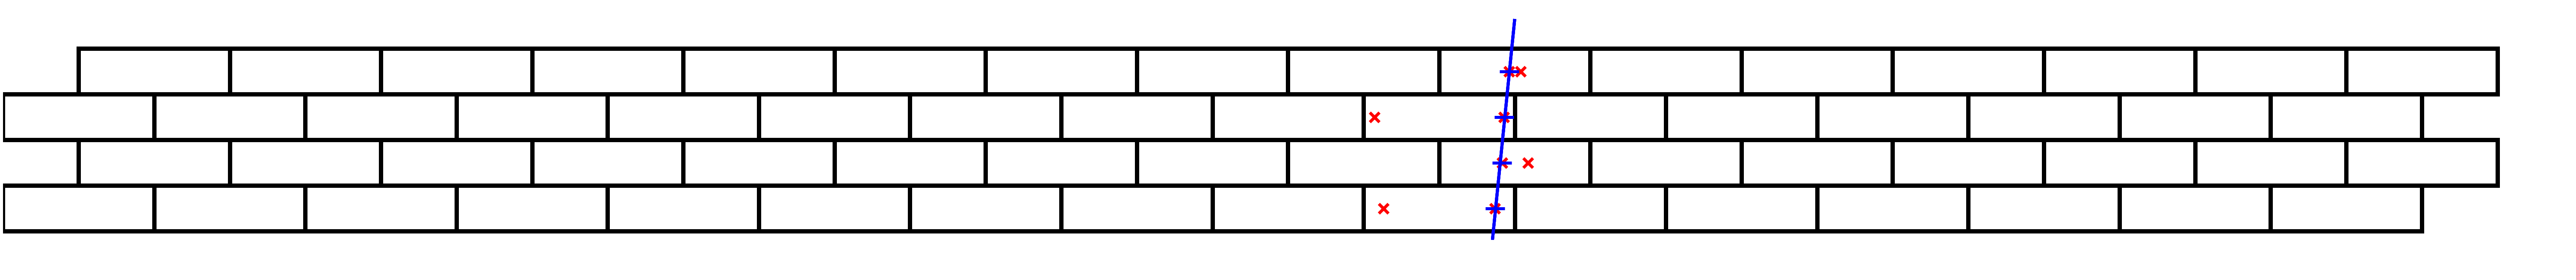

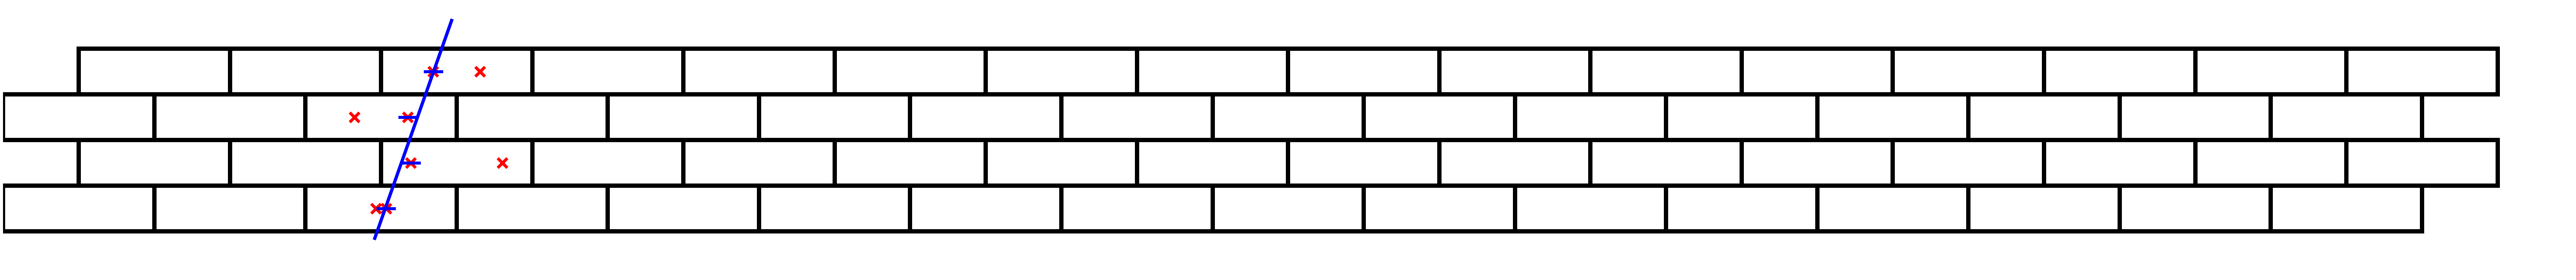

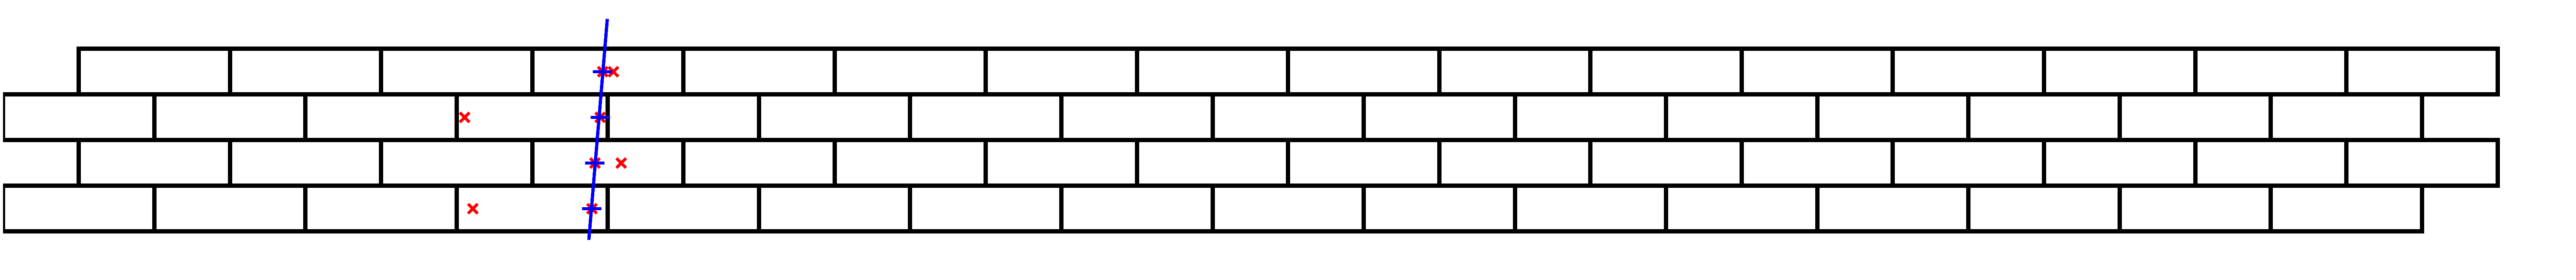

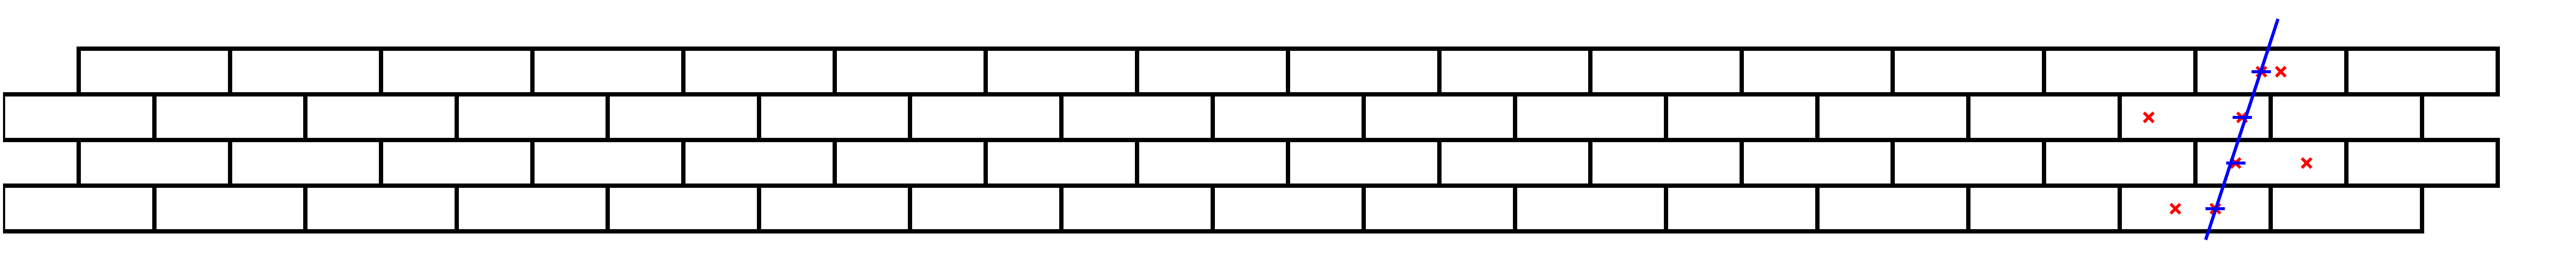

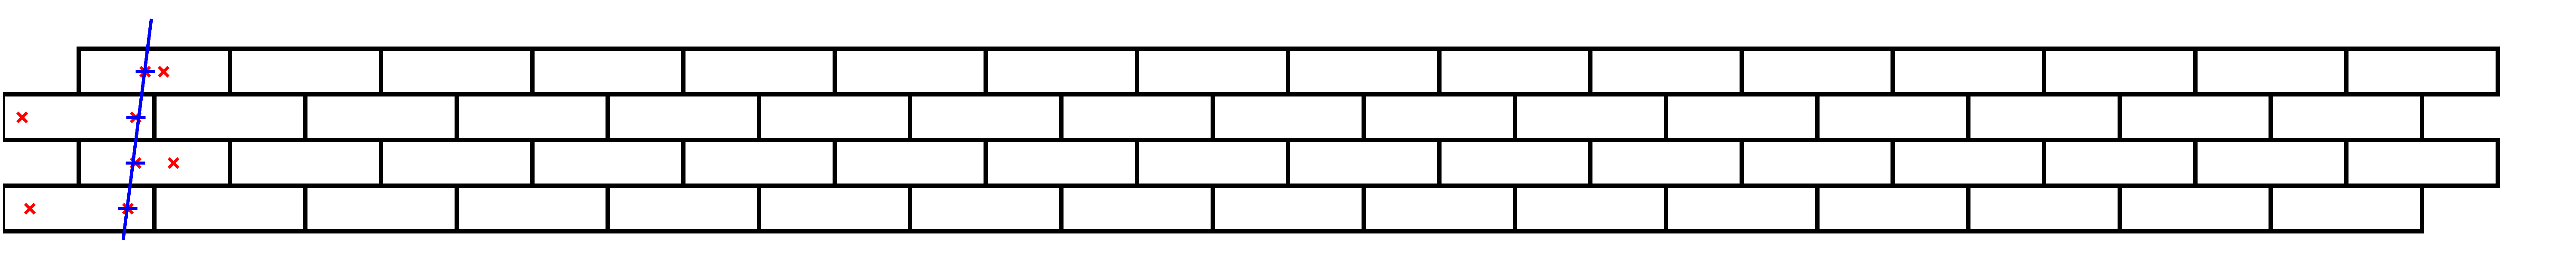

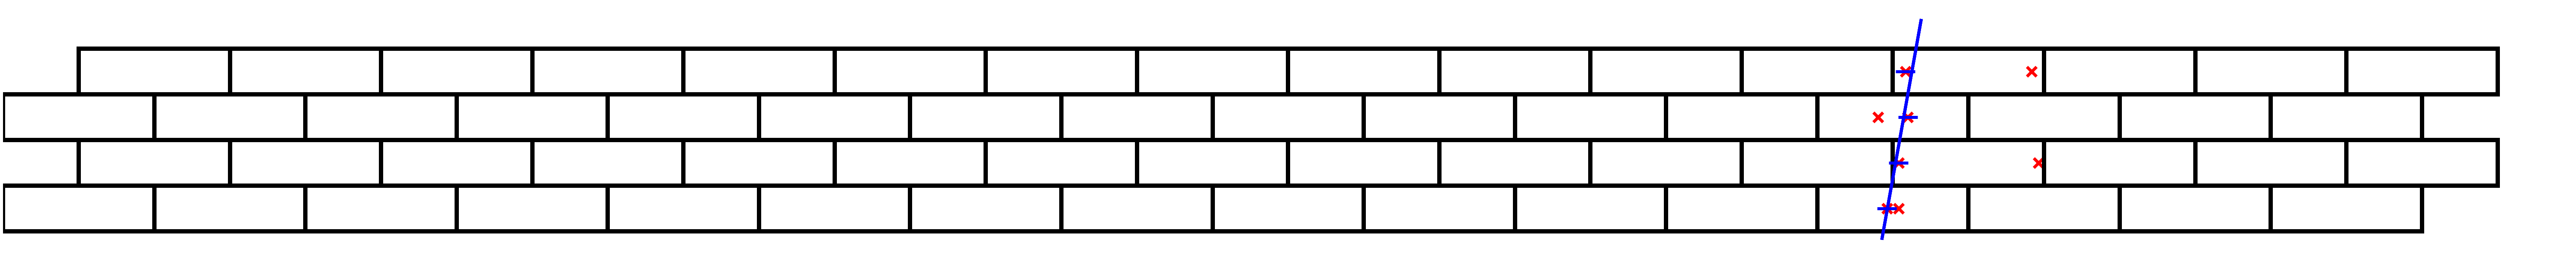

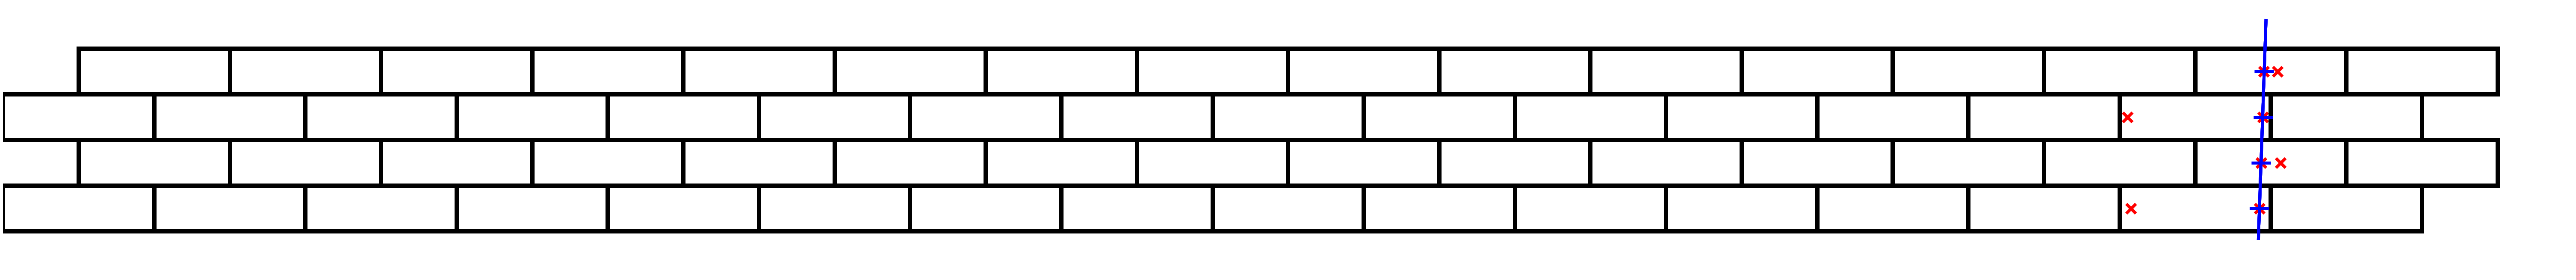

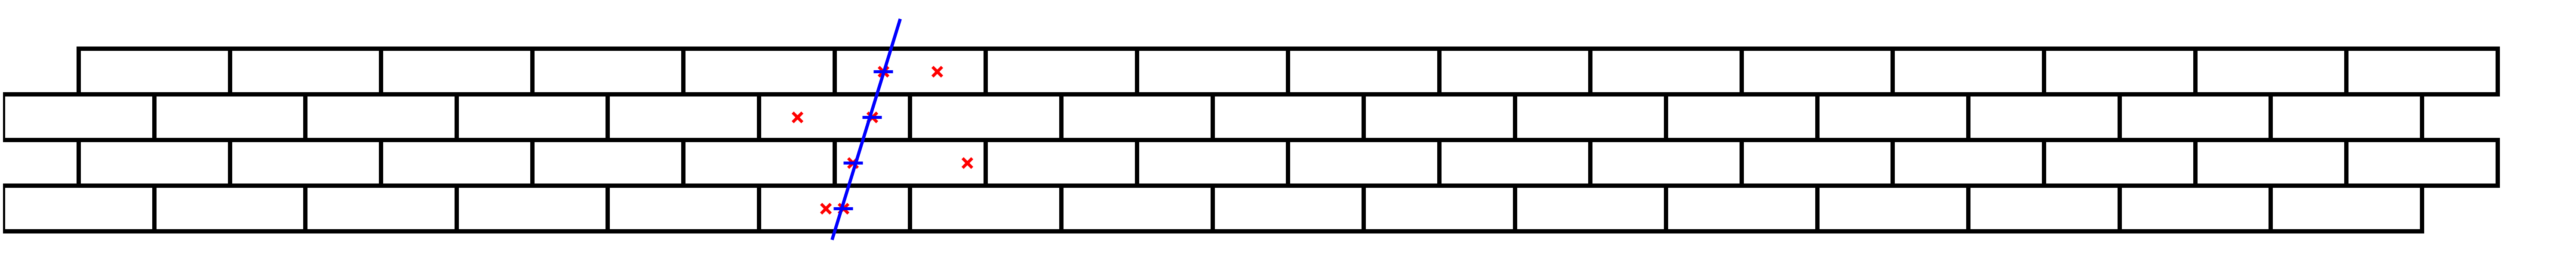

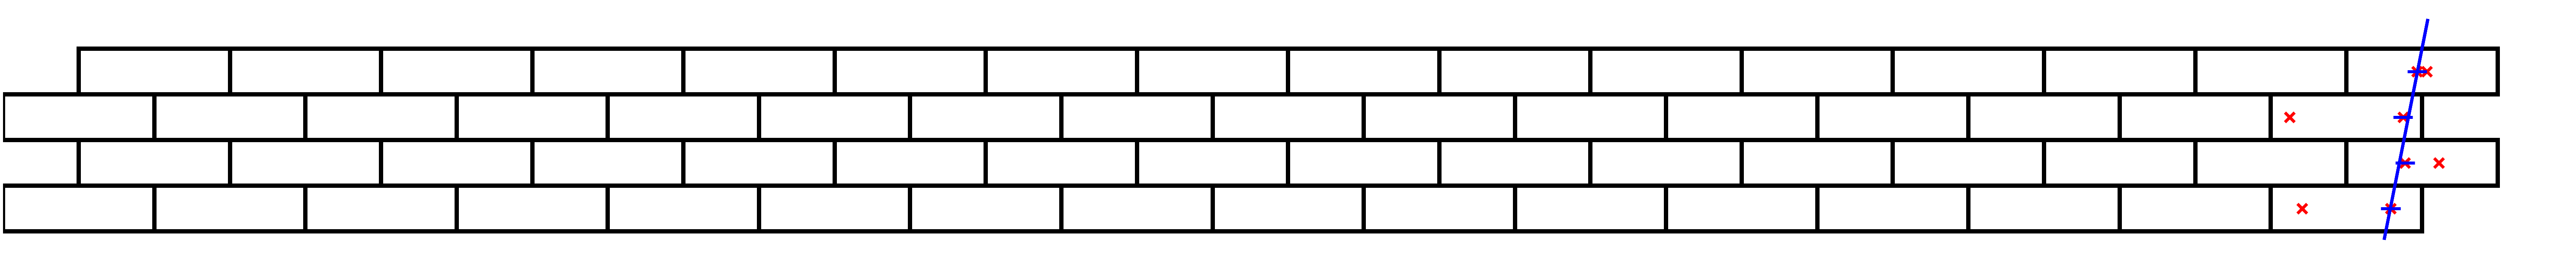

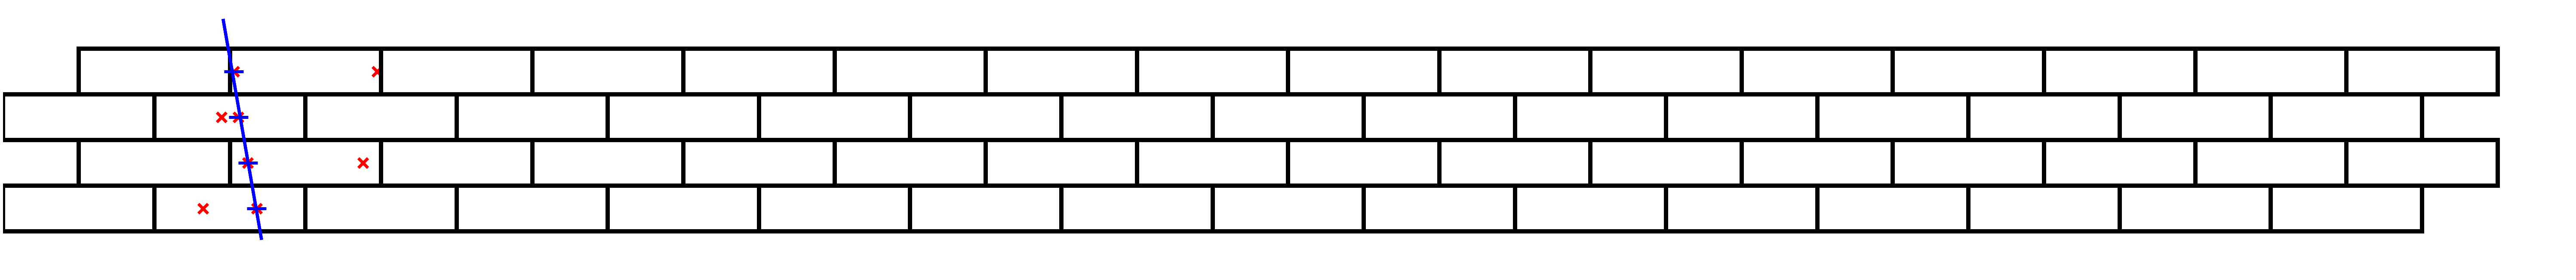

In [71]:
# adesso devo rappresentare le rette che ottengo tramite dei fit su quattro punti. 

delta_x = 42/(2*390)*(50) #l'indeterminazione sulle x è v_d*delta_t=42/(2*390)*(2*25). Calcolo questo valore fuori perché non ha senso ricalcolarlo volta per volta, è una costante

def event_and_line_plot(event):
    
    fig,ax1 = plt.subplots(figsize=(1.5*4.2*17,1.5*1.3*6))
    
    #dimensions of one cell
    dx = 42
    dy = 13
    
    #draw the detector
    ax1.set_xlim(0,42*16 + 42)
    ax1.set_ylim(-13,13*4 + 13)

    #copia inutile ma per chiarezza utilizziamo queste variabili
    xr = event['XR'].to_numpy()
    xl = event['XL'].to_numpy()
    X = event['X_BEST'].to_numpy()
    Y = event['Y'].to_numpy()

    x_1 = x_3 = np.arange(16)*dx 
    x_2 = x_4 = x_1 + dx/2
    [y_1, y_2, y_3, y_4] = np.arange(4)*dy 


    for i in range(16):
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        ax1.axis('off')
        
    ax1.scatter(xr,Y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    ax1.scatter(xl,Y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    ax1.errorbar(X, Y, xerr=delta_x, fmt='.', c = 'blue', linewidth = 7) # errorbar
    ax1.plot([(-2-event.Q)/event.M,(60-event.Q)/event.M] ,[-2,60], c= 'blue', linewidth = 7) #per rendere un po' più visibile questa retta utilizziamo come estremi per graficarla i punti di y=-2 e 60
    # avendo visto che il massimo in altezza che raggiunge il detector è circa cinquanta, affinché la retta cha rappresenta la traiettoria della particella sia visibile scelgo come limite superiore sessanta.
    return ax1

#print("Plotting reconstructed trajectories HAVING CHECKED compatibility with experimental error")
for i in np.unique(df22.index)[:10] :
    event_and_line_plot(df22.loc[i])

In [72]:
#df22.to_csv("part3v1_finito.csv")